### Система своевременного распределения излишком между 2мя производствами

#### Библиотеки

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import optuna

#### Функция генерации данных(Ларин Антон)

In [37]:
def generate_production_scenario(periods=120, seed=42, max_space=100):
    np.random.seed(seed)
    dates = pd.date_range('2024-01-01', periods=periods, freq='D')
    days = np.arange(periods)

    base_demand = 50
    seasonal_a = 20 * np.sin(2 * np.pi * days / 30)
    noise = np.random.normal(0, 2.5, periods)

    demand_a = base_demand + seasonal_a + noise
    demand_b = base_demand - seasonal_a + noise

    demand_a = np.clip(demand_a, 30, 70)
    demand_b = np.clip(demand_b, 30, 70)

    production = np.full(periods, 50)

    df_a = pd.DataFrame({
        'date': dates,
        'location': 'Factory_A',
        'production': production,
        'demand': demand_a,
        'initial_inventory': 45,
        'max_space': max_space,
        'travel': False
    })

    df_b = pd.DataFrame({
        'date': dates,
        'location': 'Factory_B',
        'production': production,
        'demand': demand_b,
        'initial_inventory': 45,
        'max_space': max_space,
        'travel': False
    })

    return pd.concat([df_a, df_b], ignore_index=True)

In [38]:
df = generate_production_scenario()
df = df[df['location'] == 'Factory_A']
cur_inv = df['initial_inventory'].iloc[0]
history = []
for i in df.values:
    history.append(cur_inv + i[2] - i[3])
df['inventory'] = history
df.head()

,date,location,production,demand,initial_inventory,max_space,travel,inventory
0,2024-01-01,Factory_A,50,51.241785,45,100,False,43.758215
1,2024-01-02,Factory_A,50,53.812573,45,100,False,41.187427
2,2024-01-03,Factory_A,50,59.753954,45,100,False,35.246046
3,2024-01-04,Factory_A,50,65.563280,45,100,False,29.436720
4,2024-01-05,Factory_A,50,64.277513,45,100,False,30.722487


<Axes: >

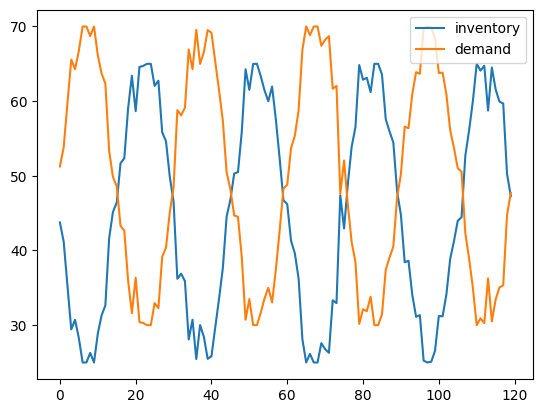

In [39]:
df[['inventory', 'demand']].plot()

In [40]:
sum(df['inventory'] > 50) / len(df) * 100

41.66666666666667

In [43]:
df.loc[len(df)-1, 'inventory'] = 190

In [42]:
df

,date,location,production,demand,initial_inventory,max_space,travel,inventory
0,2024-01-01,Factory_A,50,51.241785,45,100,False,43.758215
1,2024-01-02,Factory_A,50,53.812573,45,100,False,41.187427
2,2024-01-03,Factory_A,50,59.753954,45,100,False,35.246046
3,2024-01-04,Factory_A,50,65.563280,45,100,False,29.436720
4,2024-01-05,Factory_A,50,64.277513,45,100,False,30.722487
...,...,...,...,...,...,...,...,...
115,2024-04-25,Factory_A,50,33.433360,45,100,False,61.566640
116,2024-04-26,Factory_A,50,35.050324,45,100,False,59.949676
117,2024-04-27,Factory_A,50,35.322600,45,100,False,59.677400
118,2024-04-28,Factory_A,50,44.722324,45,100,False,50.277676


In [27]:
df.to_csv('test.csv', index=False)

#### Функция для симулирования(Окуньков Максим)

In [3]:
def simulate_warehouse_with_params(df, params, max_inventory=100, transport_delay=2):
    df_sim = df.copy()
    factories = ['Factory_A', 'Factory_B']
    dates = sorted(df_sim['date'].unique())
    n_days = len(dates)

    results = []
    inventory = {
        'Factory_A': df_sim[df_sim['location'] == 'Factory_A']['initial_inventory'].iloc[0],
        'Factory_B': df_sim[df_sim['location'] == 'Factory_B']['initial_inventory'].iloc[0]
    }

    transport_queue = {i: [] for i in range(n_days)}

    # Извлекаем параметры
    TARGET_INVENTORY = params['TARGET_INVENTORY']
    MIN_SAFE_INVENTORY = params['MIN_SAFE_INVENTORY']
    MAX_SAFE_INVENTORY = params['MAX_SAFE_INVENTORY']
    ADAPTATION_RATE = params['ADAPTATION_RATE']
    TRANSFER_THRESHOLD_EXCESS = params['TRANSFER_THRESHOLD_EXCESS']
    TRANSFER_THRESHOLD_NEEDED = params['TRANSFER_THRESHOLD_NEEDED']
    TRANSFER_RATIO = params['TRANSFER_RATIO']

    for day_idx, date in enumerate(dates):
        daily_results = []
        arrivals = {'Factory_A': 0, 'Factory_B': 0}
        for to_f, amount in transport_queue[day_idx]:
            arrivals[to_f] += amount

        for factory in factories:
            row = df_sim[(df_sim['date'] == date) & (df_sim['location'] == factory)].iloc[0]
            base_production = row['production']
            demand = row['demand']

            inventory[factory] += arrivals[factory]

            # Адаптивное производство
            inv_deviation = (inventory[factory] - TARGET_INVENTORY) / TARGET_INVENTORY
            production_adjustment = -ADAPTATION_RATE * inv_deviation
            production = base_production * (1 + production_adjustment)

            min_production = max(0.7 * base_production, 30)
            max_production = min(1.3 * base_production, 70)
            production = np.clip(production, min_production, max_production)

            # Обновление инвентаря
            inventory[factory] += production

            # Продажи
            sales = min(demand, inventory[factory])
            shortage = max(0, demand - sales)
            inventory[factory] -= sales

            # Избыток
            surplus = max(0, inventory[factory] - max_inventory)
            if surplus > 0:
                inventory[factory] = max_inventory

            # Перевозки
            transfer_amount = 0
            other_factory = 'Factory_B' if factory == 'Factory_A' else 'Factory_A'

            if (inventory[factory] > MAX_SAFE_INVENTORY + TRANSFER_THRESHOLD_EXCESS and
                inventory[other_factory] < MIN_SAFE_INVENTORY - TRANSFER_THRESHOLD_NEEDED):

                excess = inventory[factory] - MAX_SAFE_INVENTORY
                needed = MIN_SAFE_INVENTORY - inventory[other_factory]
                transfer_amount = min(excess * TRANSFER_RATIO, needed * TRANSFER_RATIO, 30)

                if transfer_amount > 5:
                    inventory[factory] -= transfer_amount
                    arrival_idx = day_idx + transport_delay
                    if arrival_idx < n_days:
                        transport_queue[arrival_idx].append((other_factory, transfer_amount))

            inventory[factory] = max(0, inventory[factory])

            daily_results.append({
                'date': date,
                'location': factory,
                'production': production,
                'demand': demand,
                'sales': sales,
                'shortage': shortage,
                'inventory_after': inventory[factory],
                'surplus_after': surplus,
                'transferred': transfer_amount
            })

        results.extend(daily_results)

    return pd.DataFrame(results)

#### Функции поиска оптимальных параметров(Беджанов Азамат)

In [4]:
def objective_function_for_optuna(trial, df):
    """
    Целевая функция для Optuna:
    Минимизируем: дефицит + избыток - время в зоне баланса
    """
    # Определяем пространство поиска параметров
    params = {
        'TARGET_INVENTORY': trial.suggest_int('TARGET_INVENTORY', 40, 60),
        'MIN_SAFE_INVENTORY': trial.suggest_int('MIN_SAFE_INVENTORY', 25, 40),
        'MAX_SAFE_INVENTORY': trial.suggest_int('MAX_SAFE_INVENTORY', 60, 80),
        'ADAPTATION_RATE': trial.suggest_float('ADAPTATION_RATE', 0.15, 0.35),
        'TRANSFER_THRESHOLD_EXCESS': trial.suggest_int('TRANSFER_THRESHOLD_EXCESS', 5, 20),
        'TRANSFER_THRESHOLD_NEEDED': trial.suggest_int('TRANSFER_THRESHOLD_NEEDED', 5, 20),
        'TRANSFER_RATIO': trial.suggest_float('TRANSFER_RATIO', 0.3, 0.7)
    }

    df_rules = simulate_warehouse_with_params(df.copy(), params)

    # Рассчитываем метрики
    total_shortage = df_rules['shortage'].sum()
    total_surplus = df_rules['surplus_after'].sum()

    # Время в зоне баланса
    days_in_balance = 0
    for factory in ['Factory_A', 'Factory_B']:
        factory_data = df_rules[df_rules['location'] == factory]
        balance_days = ((factory_data['inventory_after'] >= params['MIN_SAFE_INVENTORY']) &
                       (factory_data['inventory_after'] <= params['MAX_SAFE_INVENTORY'])).sum()
        days_in_balance += balance_days

    # Целевая функция: штраф за дефицит/избыток, бонус за баланс
    score = total_shortage + total_surplus - days_in_balance * 2

    # Добавляем промежуточные значения для визуализации прогресса
    trial.report(score, 0)

    # Опционально: ранняя остановка если результат очень плохой
    if trial.should_prune():
        raise optuna.TrialPruned()

    return score

def optimize_parameters_with_optuna(df, n_trials=100):
    """Оптимизация параметров с помощью Optuna (Bayesian Optimization)"""
    print(f"\n{ '=' * 70 }")
    print("BAYESIAN OPTIMIZATION ПАРАМЕТРОВ С ПОМОЩЬЮ OPTUNA".center(70))
    print(f"{ '=' * 70 }")
    print(f"Запуск Optuna ({n_trials} итераций)...")

    # Создаем study
    study = optuna.create_study(
        direction='minimize',
        sampler=optuna.samplers.TPESampler(seed=42),  # TPE - Tree-structured Parzen Estimator
        pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=1)
    )

    # Запускаем оптимизацию
    study.optimize(
        lambda trial: objective_function_for_optuna(trial, df.copy()),
        n_trials=n_trials,
        show_progress_bar=True
    )

    # Получаем лучшие параметры
    best_params = {
        'TARGET_INVENTORY': study.best_params['TARGET_INVENTORY'],
        'MIN_SAFE_INVENTORY': study.best_params['MIN_SAFE_INVENTORY'],
        'MAX_SAFE_INVENTORY': study.best_params['MAX_SAFE_INVENTORY'],
        'ADAPTATION_RATE': study.best_params['ADAPTATION_RATE'],
        'TRANSFER_THRESHOLD_EXCESS': study.best_params['TRANSFER_THRESHOLD_EXCESS'],
        'TRANSFER_THRESHOLD_NEEDED': study.best_params['TRANSFER_THRESHOLD_NEEDED'],
        'TRANSFER_RATIO': study.best_params['TRANSFER_RATIO']
    }

    print(f"\n Лучшие параметры:")
    print("-" * 50)
    for param, value in best_params.items():
        if isinstance(value, float):
            print(f"{param:<30} {value:.4f}")
        else:
            print(f"{param:<30} {value}")
    print("-" * 50)
    print(f"Лучшее значение целевой функции: {study.best_value:.2f}")

    return best_params


def simulate_optimized_system(df, best_params):
    return simulate_warehouse_with_params(df, best_params)

#### Функции вывода результатов в графиках и таблицах

In [5]:
def plot_optimized_comparison(df_static, df_rules, df_optimized):
    """Сравнение: статичное vs правила vs оптимизированные правила"""
    fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharex=True)
    plt.subplots_adjust(hspace=0.3, wspace=0.25)

    factories = ['Factory_A', 'Factory_B']
    titles = ['Фабрика A (сезонный спрос)', 'Фабрика B (спрос в противофазе)']
    colors = {
        'Factory_A': {
            'static': '#1f77b4',    # Синий
            'rules': '#ff7f0e',     # Оранжевый
            'optimized': '#2ca02c', # Зеленый
            'demand': '#d62728'     # Красный
        },
        'Factory_B': {
            'static': '#9467bd',    # Фиолетовый
            'rules': '#1f77b4',     # Синий
            'optimized': '#2ca02c', # Зеленый
            'demand': '#d62728'     # Красный
        }
    }

    # 1. Спрос и производство
    for i, (factory, title) in enumerate(zip(factories, titles)):
        static = df_static[df_static['location'] == factory]
        rules = df_rules[df_rules['location'] == factory]
        optimized = df_optimized[df_optimized['location'] == factory]

        # Спрос
        axes[0, i].plot(static['date'], static['demand'],
                       color=colors[factory]['demand'], linewidth=3, alpha=0.85,
                       label='Спрос', linestyle='--')

        # Производство
        axes[0, i].plot(static['date'], static['production'],
                       color='gray', linewidth=2, alpha=0.7,
                       label='Статичное (50 ед.)')
        axes[0, i].plot(rules['date'], rules['production'],
                       color=colors[factory]['rules'], linewidth=2.5, alpha=0.8,
                       label='Правила (базовые)')
        axes[0, i].plot(optimized['date'], optimized['production'],
                       color=colors[factory]['optimized'], linewidth=3.5, alpha=0.95,
                       label='Правила (оптимизированные)')

        axes[0, i].set_title(f'{title}', fontsize=14, pad=12)
        axes[0, i].set_ylabel('Единиц/день', fontsize=12)
        axes[0, i].legend(loc='upper right', fontsize=9)
        axes[0, i].grid(alpha=0.3, linestyle='--')
        axes[0, i].set_ylim(25, 75)

    # 2. Запасы
    for i, factory in enumerate(factories):
        static = df_static[df_static['location'] == factory]
        rules = df_rules[df_rules['location'] == factory]
        optimized = df_optimized[df_optimized['location'] == factory]

        axes[1, i].plot(static['date'], static['inventory_after'],
                       color=colors[factory]['static'], linewidth=2, alpha=0.7,
                       label='Статичное')
        axes[1, i].plot(rules['date'], rules['inventory_after'],
                       color=colors[factory]['rules'], linewidth=2.5, alpha=0.8,
                       label='Правила (базовые)')
        axes[1, i].plot(optimized['date'], optimized['inventory_after'],
                       color=colors[factory]['optimized'], linewidth=3.5, alpha=0.95,
                       label='Правила (оптимизированные)')

        # Зоны баланса (берем из оптимальных параметров)
        axes[1, i].axhspan(30, 70, color='green', alpha=0.1, label='Целевая зона баланса')
        axes[1, i].axhline(y=50, color='green', linestyle='--', alpha=0.7, linewidth=1.5)

        axes[1, i].set_title('Динамика складских запасов', fontsize=14, pad=12)
        axes[1, i].set_xlabel('Дата', fontsize=12)
        axes[1, i].set_ylabel('Запасы (единиц)', fontsize=12)
        axes[1, i].legend(loc='upper right', fontsize=9)
        axes[1, i].grid(alpha=0.3, linestyle='--')
        axes[1, i].set_ylim(0, 105)

    fig.suptitle('Сравнение: Статичное vs Правила vs Оптимизированные правила',
                fontsize=18, y=0.96, fontweight='bold')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    # plt.savefig('optimized_production_comparison.png', dpi=200, bbox_inches='tight')
    plt.show()

def print_optimized_statistics(df_static, df_rules, df_optimized):
    """Статистика с оптимизированными параметрами"""
    stats = []

    for name, df in [('Статичное', df_static), ('Правила (базовые)', df_rules), ('Правила (оптимизированные)', df_optimized)]:
        total_shortage = df['shortage'].sum()
        total_surplus = df['surplus_after'].sum()
        days_with_shortage = (df['shortage'] > 0).sum()
        days_with_surplus = (df['surplus_after'] > 0).sum()
        total_transfers = (df['transferred'] > 0).sum()

        days_in_balance = ((df['inventory_after'] >= 30) & (df['inventory_after'] <= 70)).sum()
        total_days = len(df) // 2

        stats.append({
            'scenario': name,
            'total_shortage': total_shortage,
            'total_surplus': total_surplus,
            'days_with_shortage': days_with_shortage,
            'days_with_surplus': days_with_surplus,
            'total_transfers': total_transfers,
            'days_in_balance': days_in_balance,
            'balance_percentage': days_in_balance / total_days * 100
        })

    print("\n" + "="*110)
    print("СРАВНЕНИЕ ЭФФЕКТИВНОСТИ: СТАТИЧНОЕ vs БАЗОВЫЕ ПРАВИЛА vs ОПТИМИЗИРОВАННЫЕ ПРАВИЛА".center(110))
    print("="*110)
    print(f"{'Метрика':<35} {'Статичное':<20} {'Базовые правила':<20} {'Оптимизированные':<20} {'Улучшение':<15}")
    print("-"*110)

    print(f"{'Суммарный дефицит':<35} {stats[0]['total_shortage']:<20.1f} {stats[1]['total_shortage']:<20.1f} {stats[2]['total_shortage']:<20.1f} {((stats[1]['total_shortage'] - stats[2]['total_shortage'])/max(1, stats[1]['total_shortage'])*100):.1f}% ↓")
    print(f"{'Суммарный избыток':<35} {stats[0]['total_surplus']:<20.1f} {stats[1]['total_surplus']:<20.1f} {stats[2]['total_surplus']:<20.1f} {((stats[1]['total_surplus'] - stats[2]['total_surplus'])/max(1, stats[1]['total_surplus'])*100):.1f}% ↓")

    print(f"\n{'Дней с дефицитом':<35} {stats[0]['days_with_shortage']:<20} {stats[1]['days_with_shortage']:<20} {stats[2]['days_with_shortage']:<20} {((stats[1]['days_with_shortage'] - stats[2]['days_with_shortage'])/max(1, stats[1]['days_with_shortage'])*100):.1f}% ↓")
    print(f"{'Дней с избытком':<35} {stats[0]['days_with_surplus']:<20} {stats[1]['days_with_surplus']:<20} {stats[2]['days_with_surplus']:<20} {((stats[1]['days_with_surplus'] - stats[2]['days_with_surplus'])/max(1, stats[1]['days_with_surplus'])*100):.1f}% ↓")

    print(f"\n{'Дней в зоне баланса (30-70)':<35} {stats[0]['days_in_balance']:<20} {stats[1]['days_in_balance']:<20} {stats[2]['days_in_balance']:<20} {stats[2]['balance_percentage'] - stats[1]['balance_percentage']:.1f}% ↑")
    print(f"{'% времени в балансе':<35} {stats[0]['balance_percentage']:<20.1f}% {stats[1]['balance_percentage']:<20.1f}% {stats[2]['balance_percentage']:<20.1f}% {stats[2]['balance_percentage'] - stats[1]['balance_percentage']:.1f}% ↑")

    print(f"\n{'Количество перевозок':<35} {stats[0]['total_transfers']:<20} {stats[1]['total_transfers']:<20} {stats[2]['total_transfers']:<20} -")

    print("="*110)
    print("\n🎯 КЛЮЧЕВЫЕ ВЫВОДЫ ПО ОПТИМИЗАЦИИ:")
    shortage_improvement = ((stats[1]['total_shortage'] - stats[2]['total_shortage']) / max(1, stats[1]['total_shortage'])) * 100
    surplus_improvement = ((stats[1]['total_surplus'] - stats[2]['total_surplus']) / max(1, stats[1]['total_surplus'])) * 100
    balance_improvement = stats[2]['balance_percentage'] - stats[1]['balance_percentage']

    print(f"• Оптимизация сократила дефицит на {shortage_improvement:.1f}% и избыток на {surplus_improvement:.1f}% по сравнению с базовыми правилами")
    print(f"• Время в зоне баланса увеличилось на {balance_improvement:.1f}%")
    print("="*110)

#### Main

In [6]:
# Генерация данных
df = generate_production_scenario(periods=120, seed=42)

# 1. Статичное производство
df_static = simulate_warehouse_with_params(
    df.copy(),
    params={
        'TARGET_INVENTORY': 50,
        'MIN_SAFE_INVENTORY': 30,
        'MAX_SAFE_INVENTORY': 70,
        'ADAPTATION_RATE': 0.0,
        'TRANSFER_THRESHOLD_EXCESS': 0,
        'TRANSFER_THRESHOLD_NEEDED': 0,
        'TRANSFER_RATIO': 0.0
    }
)

base_params = {
    'TARGET_INVENTORY': 50,
    'MIN_SAFE_INVENTORY': 30,
    'MAX_SAFE_INVENTORY': 70,
    'ADAPTATION_RATE': 0.25,
    'TRANSFER_THRESHOLD_EXCESS': 10,
    'TRANSFER_THRESHOLD_NEEDED': 10,
    'TRANSFER_RATIO': 0.4
}

In [7]:
df_rules = simulate_warehouse_with_params(df.copy(), base_params)

best_params = optimize_parameters_with_optuna(df.copy(), n_trials=80)

df_optimized = simulate_optimized_system(df.copy(), best_params)

[I 2025-12-04 20:39:09,905] A new study created in memory with name: no-name-e395fd51-b111-49c3-90a9-4d6c874aaf31



          BAYESIAN OPTIMIZATION ПАРАМЕТРОВ С ПОМОЩЬЮ OPTUNA           
Запуск Optuna (80 итераций)...


  0%|          | 0/80 [00:00<?, ?it/s]

[I 2025-12-04 20:39:10,084] Trial 0 finished with value: -51.112909004085964 and parameters: {'TARGET_INVENTORY': 47, 'MIN_SAFE_INVENTORY': 40, 'MAX_SAFE_INVENTORY': 75, 'ADAPTATION_RATE': 0.2697316968394073, 'TRANSFER_THRESHOLD_EXCESS': 7, 'TRANSFER_THRESHOLD_NEEDED': 7, 'TRANSFER_RATIO': 0.3232334448672798}. Best is trial 0 with value: -51.112909004085964.
[I 2025-12-04 20:39:10,236] Trial 1 finished with value: 265.87936811786517 and parameters: {'TARGET_INVENTORY': 58, 'MIN_SAFE_INVENTORY': 34, 'MAX_SAFE_INVENTORY': 74, 'ADAPTATION_RATE': 0.1541168988591605, 'TRANSFER_THRESHOLD_EXCESS': 20, 'TRANSFER_THRESHOLD_NEEDED': 18, 'TRANSFER_RATIO': 0.38493564427131044}. Best is trial 0 with value: -51.112909004085964.
[I 2025-12-04 20:39:10,409] Trial 2 finished with value: -85.15639022059963 and parameters: {'TARGET_INVENTORY': 43, 'MIN_SAFE_INVENTORY': 27, 'MAX_SAFE_INVENTORY': 66, 'ADAPTATION_RATE': 0.25495128632644753, 'TRANSFER_THRESHOLD_EXCESS': 11, 'TRANSFER_THRESHOLD_NEEDED': 9, 'T

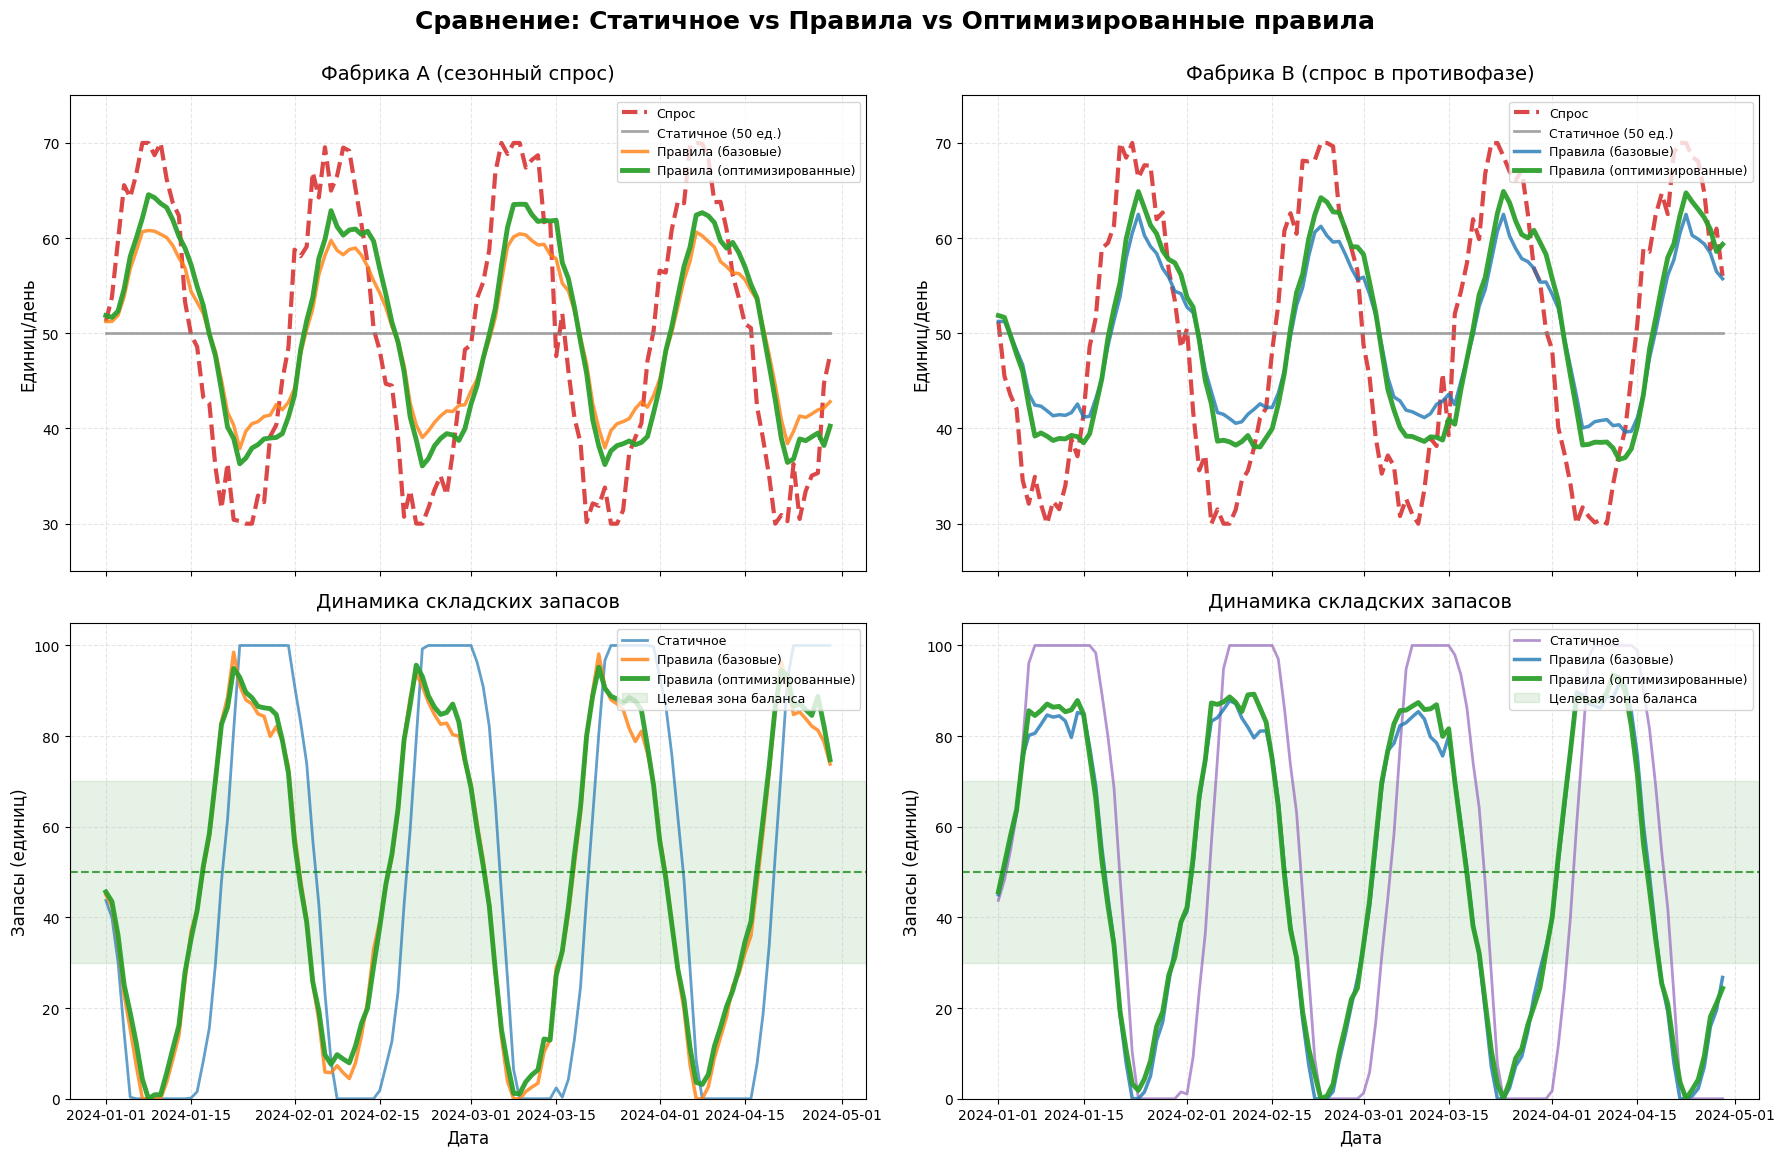

In [8]:
plot_optimized_comparison(df_static, df_rules, df_optimized)

In [9]:
print_optimized_statistics(df_static, df_rules, df_optimized)


              СРАВНЕНИЕ ЭФФЕКТИВНОСТИ: СТАТИЧНОЕ vs БАЗОВЫЕ ПРАВИЛА vs ОПТИМИЗИРОВАННЫЕ ПРАВИЛА               
Метрика                             Статичное            Базовые правила      Оптимизированные     Улучшение      
--------------------------------------------------------------------------------------------------------------
Суммарный дефицит                   740.5                38.2                 3.5                  90.8% ↓
Суммарный избыток                   779.6                17.3                 3.3                  80.8% ↓

Дней с дефицитом                    60                   17                   4                    76.5% ↓
Дней с избытком                     63                   6                    3                    50.0% ↓

Дней в зоне баланса (30-70)         38                   64                   62                   -1.7% ↑
% времени в балансе                 31.7                % 53.3                % 51.7                % -1.7% ↑

Количество пер